In [1]:
%pylab inline
import tqdm
import pybinding as pb
from scipy.linalg import block_diag
from types import SimpleNamespace

Populating the interactive namespace from numpy and matplotlib


In [2]:
def surf_dos(u=-1.5, C=0.2, tx=1, ty=1, R=100, num_pts=10, phi0=0, phiN=2*pi,
             eran=linspace(-1,1,1000), broadening=0.01, show_tqdm=False):
    '''
    This function calculates local density of states on the edge of a
    coupled BHZ model.
    The considered geometry is circle.
    

    u = -1.5 # QWZ parameter
    C = 0.2  # BHZ coupling parameter
    R = 100 # Radius of the circle
    num_pts=10 # number of points to sample the edge
    eran=linspace(-1,1,1000) # energy range for the local dos calculations
    broadening=0.01 # energy broadening of LDOS calculation
    
    A SimpleNamespace object with all input parameters and also all relevant 
    calculated objects is returned.
    '''
    
    args=locals() # this is only a clever way to remember the input parameters
    # define pauli matrix
    sx = array([[0,1],
                [1,0]])
    sy = array([[0,-1j],
                [1j,0]])
    sz = array([[1,0],
                [0,-1]])

    # onsite and hopping terms defining the BHZ model with TRS^2=-1 coupling C
    U  = u*block_diag(sz,conj(sz))+C*kron(sy,sy)
    Tx = block_diag(sz+1.j*sx,conj(sz+1.j*sx))/2.
    Ty = block_diag(sz+1.j*sy,conj(sz+1.j*sy))/2.   
    
    # definition of the lattice to be a simple square lattice
    latt = pb.Lattice([1,0],[0,1])
    latt.add_one_sublattice('A',[0],U)
    latt.add_one_hopping([1,0],'A','A',Tx*tx)
    latt.add_one_hopping([0,1],'A','A',Ty*ty)
    
    # define shape
    shape = pb.circle(R)
    
    # build pybinding model
    model = pb.Model(latt,shape)
    
    # positions to calculate ldos
    phiran=linspace(phi0,phiN,num_pts)
    pts = array([cos(phiran),sin(phiran)])*R
    
    # prepare kpm object
    kpm=pb.kpm(model,silent=True)

    # just an option to use or not to use tqdm
    pran=pts.T
    if show_tqdm:
        pran=tqdm.tqdm_notebook(pts.T)
        
    # we return a SimpleNamespace object with all input 
    # parameters and also all relevant calculated objects
    
    return SimpleNamespace(args=args,
                           eran=eran,
                           phiran=phiran,
                           model=model,
                           points=pts,
                           ldos_data=[kpm.calc_ldos(energy=eran,
                                                    broadening=0.01,
                                                    position=p) 
                                      for p in pran ])

In [7]:
result = surf_dos(u=0,C=0.1,
                  R=100,num_pts=50,
                  eran=linspace(-.25,.25,500),phi0=0,phiN=pi/2,
                  broadening=.1,show_tqdm=True)

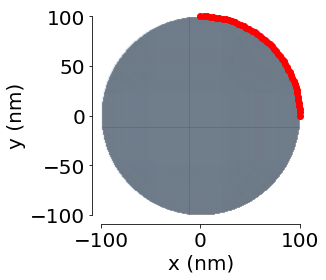

In [8]:
result.model.plot()
plot(*result.points,'ro')

In [9]:
plt.rcParams['font.size']=20

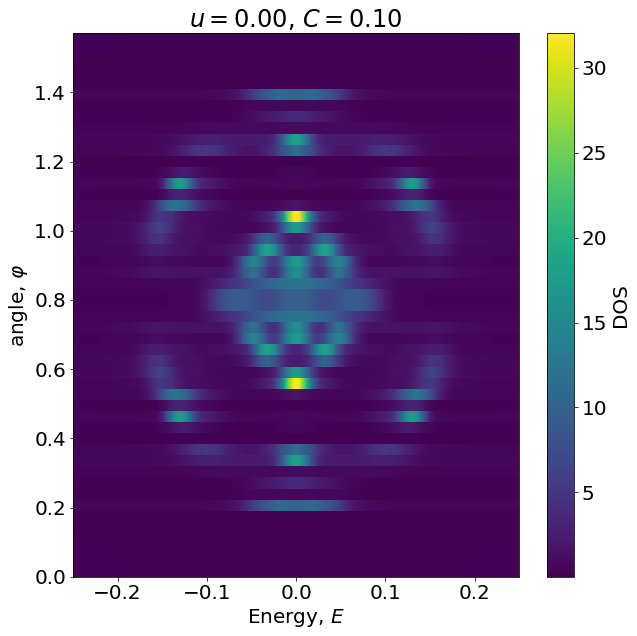

In [10]:
figure(figsize=(10,10))
pcolormesh(result.eran,result.phiran,array([l.data for l in result.ldos_data]))
cax=colorbar()
cax.set_label('DOS')
xlabel(r'Energy, $E$')
ylabel(r'angle, $\varphi$')
title(f"$u=${result.args['u']:.2f}, $C=${result.args['C']:.2f}");

